In [150]:
import os
import tqdm
import numpy as np

import ase
from ase import data
from ase.visualize import view
from ase import io
from ase.geometry import analysis

import matplotlib.pyplot as plt
import seaborn as sns

elements = ["H", "C", "N", "O", "F", "Si", "P", "S", "Cl", "Br"]

In [128]:
def load_xyz(fname):
    xyzs = []
    Zs = []

    with open(fname) as f:
        line = f.readline().strip()
        N = int(line)

        _ = f.readline().strip()

        for i, line in enumerate(f):
            if i >= N:
                break
            wds = line.split()
            Z = int(wds[0])
            xyzs.append((float(wds[1]), float(wds[2]), float(wds[3])))
            Zs.append(Z)

    xyzs = np.array(xyzs, dtype=np.float64)
    Zs = np.array(Zs, dtype=np.int32)

    mol = ase.Atoms(numbers=Zs, positions=xyzs)

    return mol

In [163]:
def get_bond_length_dictionary(molecules: list[ase.Atoms]):
    distances = {}
    for mol in tqdm.tqdm(molecules):
        #ana = analysis.Analysis(mol)
        #unique_bonds = ana.all_bonds[0]

        all_distances = mol.get_all_distances(mic=True)
        all_species = mol.get_chemical_symbols()

        for i, atom_i in enumerate(mol):
            for j, atom_j in enumerate(mol):
                if i == j:
                    continue

                bond = (all_species[i], all_species[j])
                if bond not in distances:
                    distances[bond] = []

                dist = all_distances[i, j]

                # Skip H-H bonds
                if bond == ("H", "H"):
                    continue

                # Check if dist is smaller than the sum of the covalent radii
                # https://en.wikipedia.org/wiki/Covalent_radius

                cov1 = data.covalent_radii[atom_i.number]
                cov2 = data.covalent_radii[atom_j.number]

                if dist < 1.2 * (cov1 + cov2):
                    distances[bond].append(all_distances[i, j])
                
    return distances

In [169]:
molecule_dir = '/l/mol_database/'
molecules = [
    load_xyz(os.path.join(molecule_dir, fname))
    for i, fname in enumerate(os.listdir(molecule_dir))
    #if i < 1000
]

In [170]:
bld = get_bond_length_dictionary(molecules)

100%|██████████| 81086/81086 [01:50<00:00, 732.27it/s]


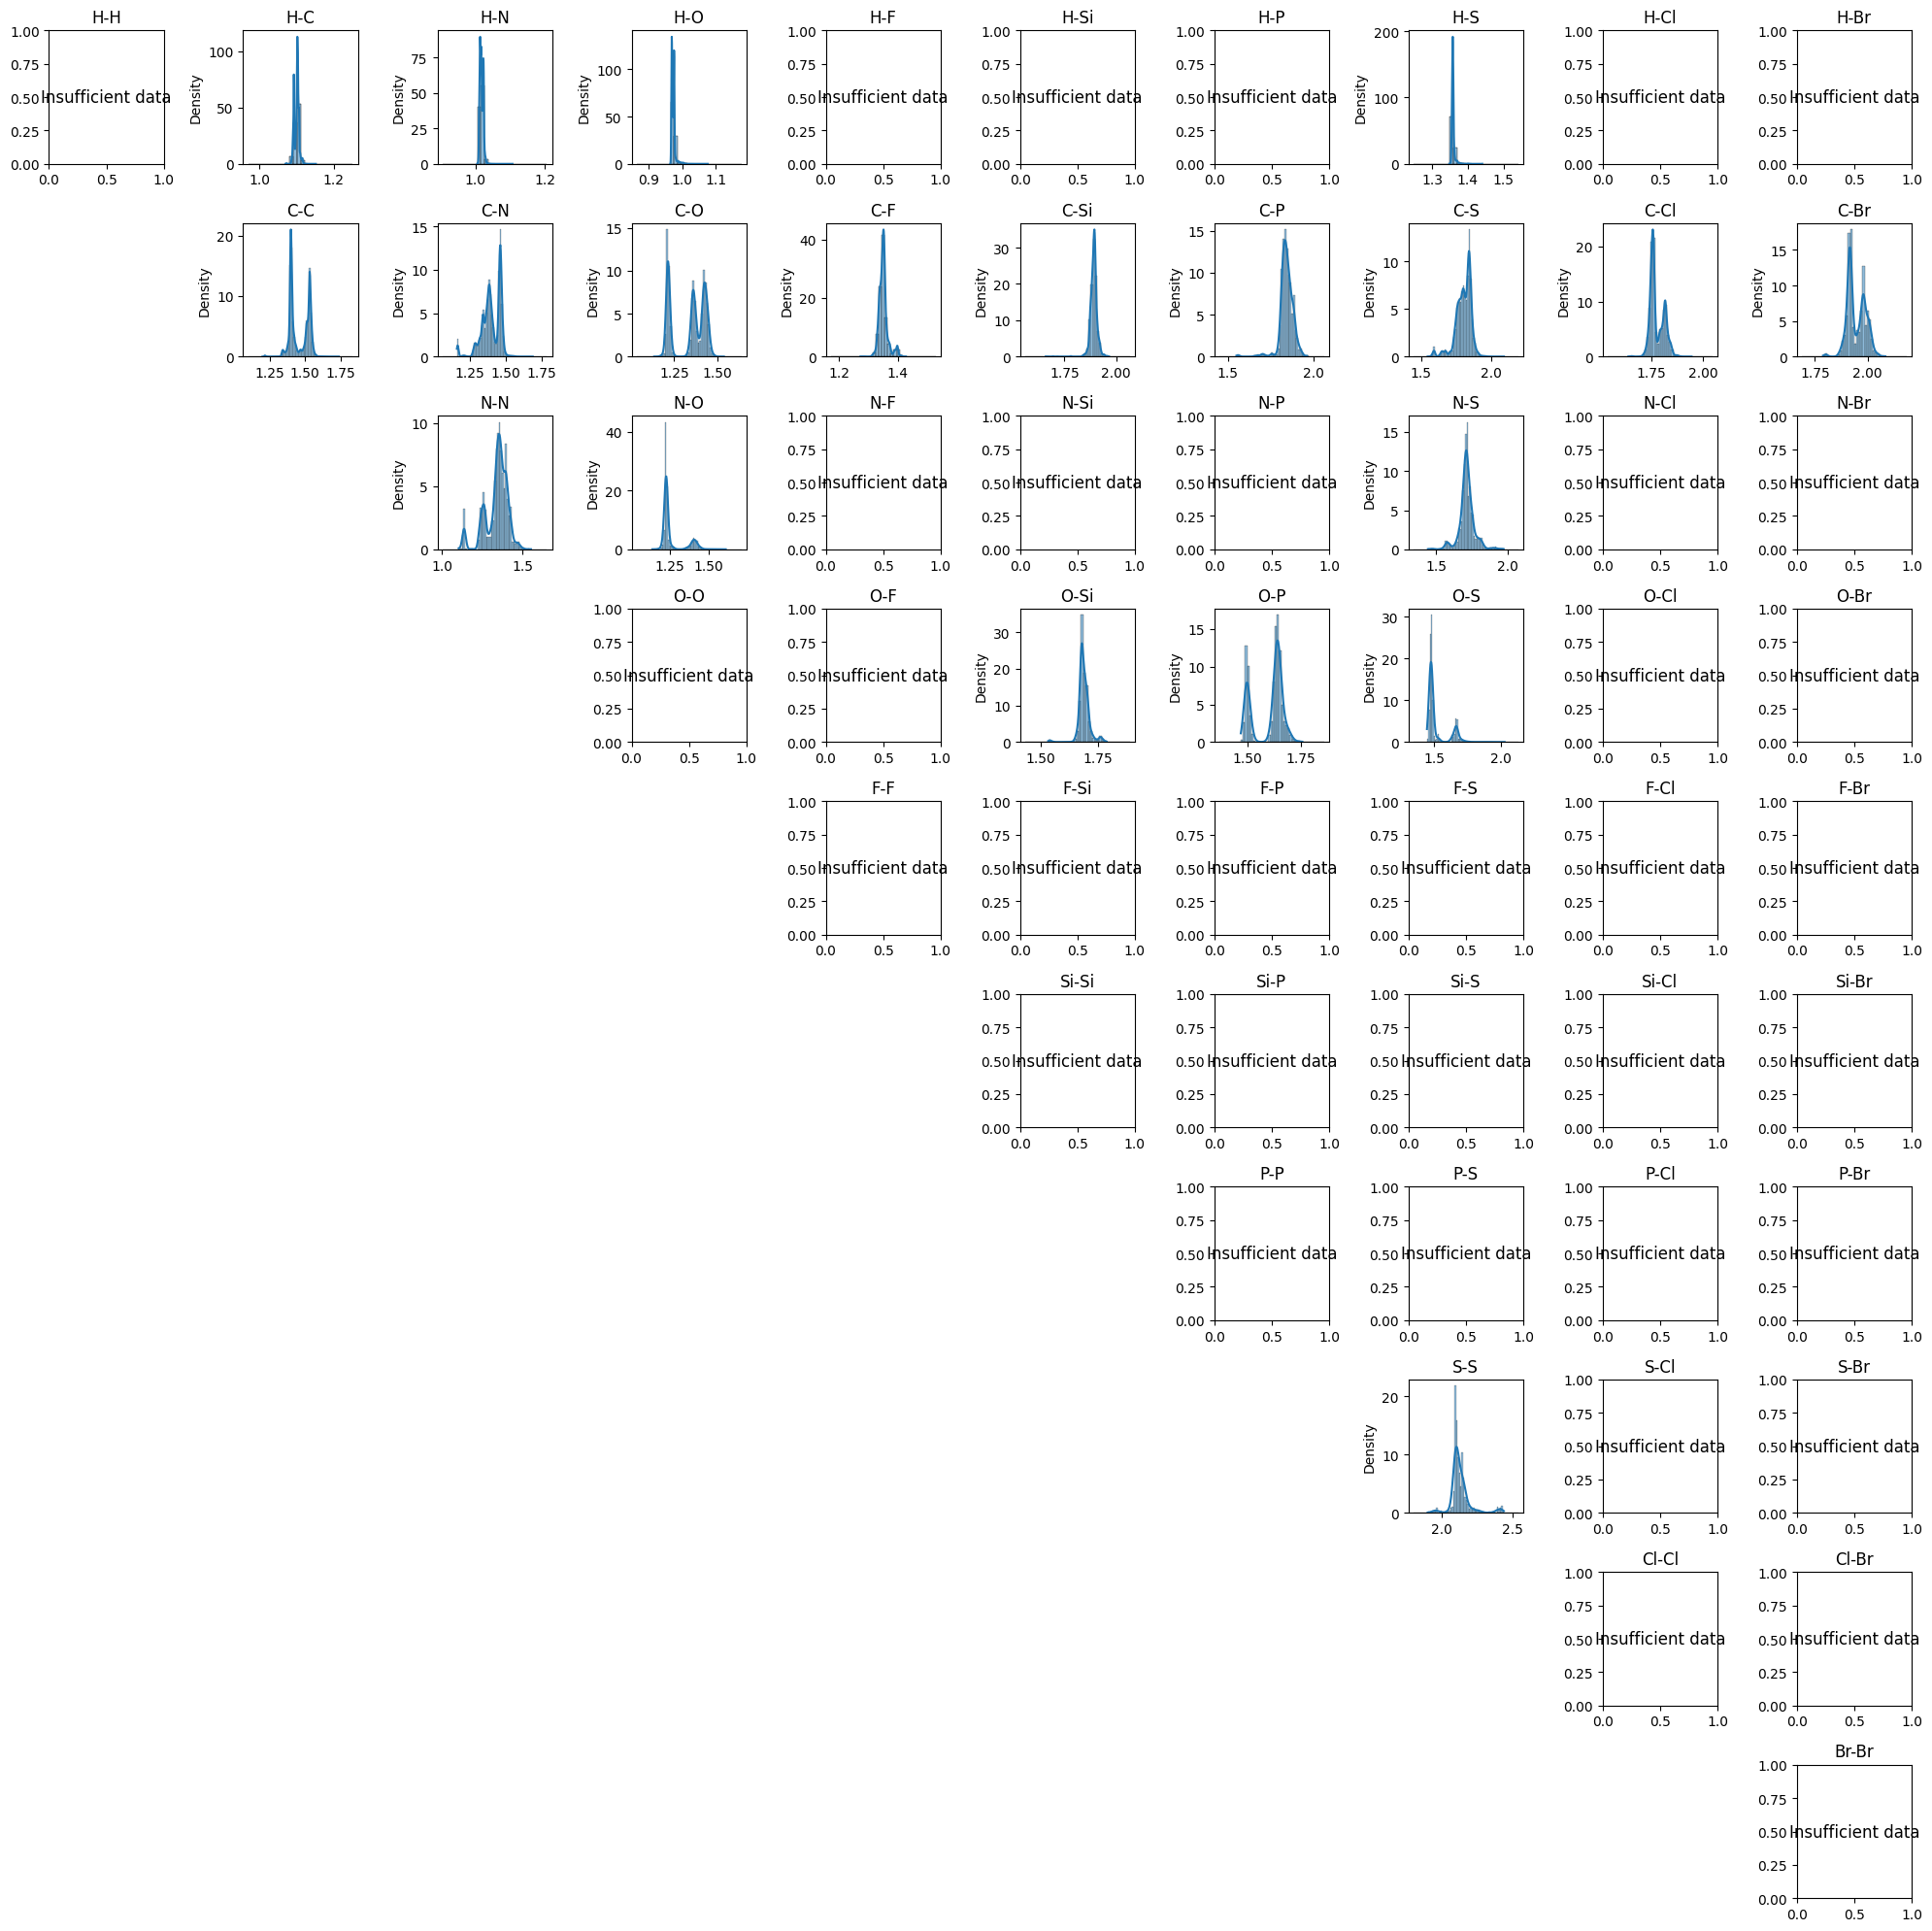

In [173]:
# Plot bond length histograms for all combinations of atom types in list `elements`

fig = plt.figure(figsize=(20, 20))
for i, element1 in enumerate(elements):
    for j, element2 in enumerate(elements):
        if i > j:
            continue

        ax = plt.subplot(len(elements), len(elements), i * len(elements) + j + 1)
        key = (element1, element2)
        if key not in bld or len(bld[key]) < 1000:
            # No data for this combination, empty plot with text "No data"
            ax.text(0.5, 0.5, "Insufficient data", horizontalalignment='center', verticalalignment='center', fontsize=12)
            ax.set_title(f"{element1}-{element2}")
            #ax.axis('off')
            continue

        # Plot histogram
        # Bind range should be adjusted to the range of min and max bond lengths 
        # for the given atom types
        bond_range = (
            min(bld[key]) - 0.1,
            max(bld[key]) + 0.1
        )
        sns.histplot(
            bld[(element1, element2)],
            kde=True,
            stat="density",
            binrange=bond_range,
            binwidth=0.01,
            ax=ax
        )
        ax.set_title(f"{element1}-{element2}")

plt.tight_layout()
plt.show()